# Topic Modeling: Yelp Business Reviews

## Imports & Settings

In [1]:
% matplotlib inline
import warnings
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, FloatRangeSlider

# spacy for language processing
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# sklearn for feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for topic models
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

# topic model viz
import pyLDAvis
from pyLDAvis.gensim import prepare

In [2]:
plt.style.use('fivethirtyeight')
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [15]:
stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words',
                             header=None,
                             squeeze=True).tolist())

In [3]:
experiment_path = Path('experiments')
data_path = Path('data')
clean_path = Path('data', 'clean_reviews.txt')

## Load Yelp Reviews

In [4]:
reviews = pd.read_parquet(data_path / 'combined_tb.parquet', engine='fastparquet')
reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5996995 entries, 0 to 5996995
Data columns (total 26 columns):
cool                  5996995 non-null int64
funny                 5996995 non-null int64
stars                 5996995 non-null int64
text                  5996995 non-null object
useful                5996995 non-null int64
year                  5996995 non-null int64
month                 5996995 non-null int64
average_stars         5996995 non-null float64
compliment_cool       5996995 non-null int64
compliment_cute       5996995 non-null int64
compliment_funny      5996995 non-null int64
compliment_hot        5996995 non-null int64
compliment_list       5996995 non-null int64
compliment_more       5996995 non-null int64
compliment_note       5996995 non-null int64
compliment_photos     5996995 non-null int64
compliment_plain      5996995 non-null int64
compliment_profile    5996995 non-null int64
compliment_writer     5996995 non-null int64
cool_user             5996995

### Tokens per review

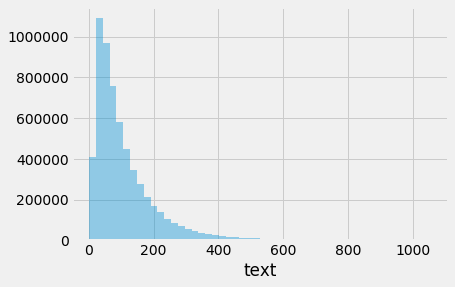

In [5]:
sns.distplot(reviews.text.str.split().str.len(), kde=False);

In [10]:
token_count = Counter()
for i, doc in enumerate(reviews.text.tolist(), 1):
    if i % 1e6 == 0:
        print(i, end=' ', flush=True)
    token_count.update(doc.split())

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 3500000 3600000 3700000 3800000 3900000 4000000 4100000 4200000 4300000 4400000 4500000 4600000 4700000 4800000 4900000 5000000 5100000 5200000 5300000 5400000 5500000 5600000 5700000 5800000 5900000 

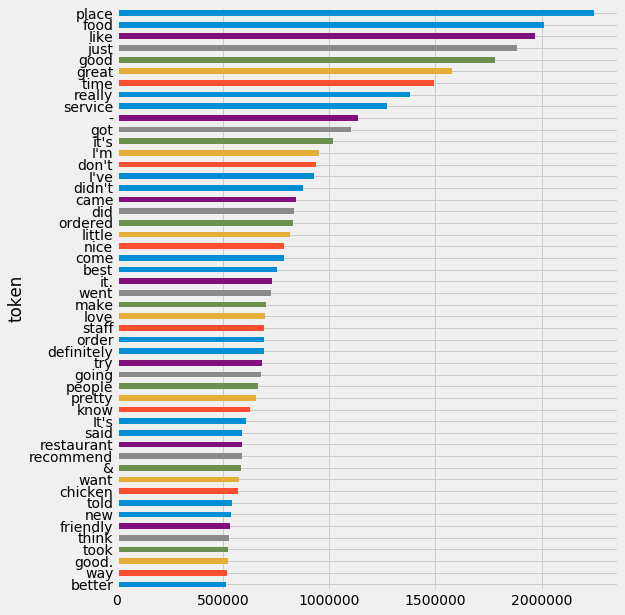

In [11]:
(pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
 .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)])
 .set_index('token')
 .squeeze()
 .iloc[:50]
 .sort_values()
 .plot
 .barh(figsize=(8, 10)));

### Preprocessing

In [12]:
def clean_doc(d):
    doc = []
    for t in d:
        if not any([t.is_stop, t.is_digit, not t.is_alpha, t.is_punct, t.is_space, t.lemma_ == '-PRON-']):        
            doc.append(t.lemma_)
    return ' '.join(doc)    

In [23]:
nlp = spacy.load('en')
nlp.max_length = 6000000
nlp.disable_pipes('ner')

[('ner', <spacy.pipeline.EntityRecognizer at 0x7f5b8955fe08>)]

In [24]:
nlp.pipe_names

['tagger', 'parser']

In [ ]:
iter_reviews = (review for review in reviews.text)
clean_reviews = []
for i, doc in enumerate(nlp.pipe(iter_reviews, batch_size=100, n_threads=8)):
    if i % 10000 == 0: 
        print(f'{i/len(reviews):.2%}', end=' ', flush=True)
    clean_reviews.append(clean_doc(doc))

In [ ]:
clean_reviews = [clean_doc(doc) for doc in parsed_reviews]

In [ ]:
clean_path.write_text('\n'.join(clean_reviews))

## Vectorize data

In [6]:
docs = clean_path.read_text().split('\n')
len(docs)

5990000

### Explore cleaned data

In [24]:
review_length, token_count = [], Counter()
for i, doc in enumerate(docs, 1):
    if i % 1e6 == 0:
        print(i, end=' ', flush=True)
    d = doc.split()
    review_length.append(len(d))
    token_count.update(d)

1000000 2000000 3000000 4000000 5000000 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


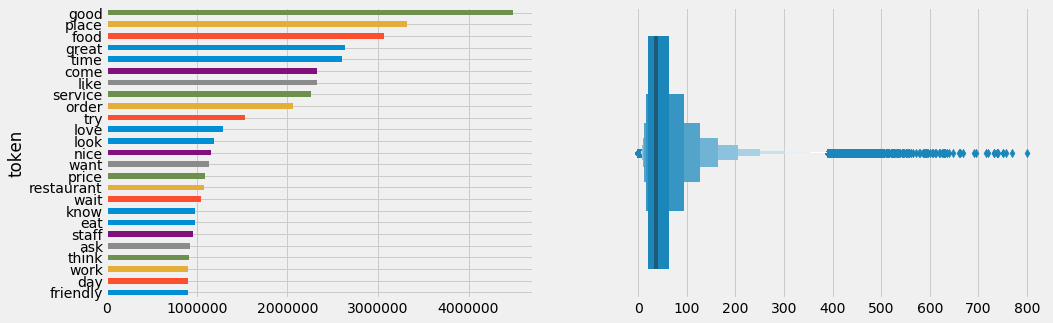

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
(pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
 .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)])
 .set_index('token')
 .squeeze()
 .iloc[:25]
 .sort_values()
 .plot
 .barh(ax=axes[0]))

sns.boxenplot(x=pd.Series(review_length), ax=axes[1]);

In [44]:
pd.Series(review_length).describe(percentiles=np.arange(.1, 1.0, .1))

count   5,990,000.00
mean           50.88
std            46.50
min             0.00
10%            14.00
20%            18.00
30.0%          24.00
40%            29.00
50%            36.00
60%            45.00
70%            57.00
80%            74.00
90%           105.00
max           799.00
dtype: float64

In [7]:
docs[:2]

['the pizza okay not good prefer biaggio flamingo fort apache the chef much good ny style pizza the pizzeria cosmo price quality lack personality food biaggio good pick go italian family own home recipe people actually care like food not pizzeria casino not care',
 'love place fiance and atleast week the portion huge food amazing love carne asada great lunch special leticia super nice care think restaurant try cheese enchilada sauce different and amazing']

In [10]:
reviews.text.head(2)

0    The pizza was okay. Not the best I've had. I p...
1    I love this place! My fiance And I go here atl...
Name: text, dtype: object

### Set vocab parameters

In [ ]:
min_df = 1000
max_df = .2
ngram_range = (1, 1)
binary = False

In [319]:
vectorizer = CountVectorizer(stop_words='english',
                             min_df=min_df,
                             max_df=max_df,
                             ngram_range=ngram_range,
                             binary=binary)
dtm = doc_vect.fit_transform(docs)
tokens = doc_vect.get_feature_names()
dtm.shape

In [321]:
corpus = Sparse2Corpus(dtm, documents_columns=False)
id2word = pd.Series(tokens).to_dict()
dictionary = Dictionary.from_corpus(corpus, id2word)

## Train & Evaluate LDA Model

In [45]:
def show_word_list(model, corpus, top=10, save=False):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    words, probs = [], []
    for top_topic, _ in top_topics:
        words.append([t[1] for t in top_topic[:top]])
        probs.append([t[0] for t in top_topic[:top]])

    fig, ax = plt.subplots(figsize=(model.num_topics*1.2, 5))
    sns.heatmap(pd.DataFrame(probs).T,
                annot=pd.DataFrame(words).T,
                fmt='',
                ax=ax,
                cmap='Blues',
                cbar=False)
    fig.tight_layout()
    if save:
        fig.savefig('yelp_wordlist', dpi=300)

In [46]:
def show_coherence(model, corpus, tokens, top=10, cutoff=0.01):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    word_lists = pd.DataFrame(model.get_topics().T, index=tokens)
    order = []
    for w, word_list in word_lists.items():
        target = set(word_list.nlargest(top).index)
        for t, (top_topic, _) in enumerate(top_topics):
            if target == set([t[1] for t in top_topic[:top]]):
                order.append(t)

    fig, axes = plt.subplots(ncols=2, figsize=(15,5))
    title = f'# Words with Probability > {cutoff:.2%}'
    (word_lists.loc[:, order]>cutoff).sum().reset_index(drop=True).plot.bar(title=title, ax=axes[1]);

    umass = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    pd.Series([c[1] for c in umass]).plot.bar(title='Topic Coherence', ax=axes[0])
    fig.tight_layout();

In [47]:
def show_top_docs(model, corpus, docs):
    doc_topics = model.get_document_topics(corpus)
    df = pd.concat([pd.DataFrame(doc_topic, 
                                 columns=['topicid', 'weight']).assign(doc=i) 
                    for i, doc_topic in enumerate(doc_topics)])

    for topicid, data in df.groupby('topicid'):
        print(topicid, docs[int(data.sort_values('weight', ascending=False).iloc[0].doc)])
        print(pd.DataFrame(exp_lda.show_topic(topicid=topicid)))

In [322]:
num_topics=25
chunksize=2000
passes=10
update_every=None
alpha='auto'
eta='auto'
decay=0.5
offset=1.0
eval_every=None
iterations=50
gamma_threshold=0.001
minimum_probability=0.01
minimum_phi_value=0.01
per_word_topics=False

In [323]:
%%time
lda_model = LdaModel(corpus=doc_corpus,
                     id2word=doc_id2word,
                     num_topics=num_topics,
                     chunksize=chunksize,
                     update_every=update_every,
                     alpha=alpha,
                     eta=eta,
                     decay=decay,
                     offset=offset,
                     eval_every=eval_every,
                     passes=passes,
                     iterations=iterations,
                     gamma_threshold=gamma_threshold,
                     minimum_probability=minimum_probability,
                     minimum_phi_value=minimum_phi_value,
                     random_state=42)

CPU times: user 55.3 s, sys: 8.76 s, total: 1min 4s
Wall time: 51.7 s


In [ ]:
2 ** (-exp_lda.log_perplexity(exp_test_corpus))

In [ ]:
show_word_list(model=exp_lda, corpus=exp_corpus)

In [ ]:
show_coherence(model=exp_lda, corpus=exp_corpus, tokens=exp_tokens)

In [325]:
vis = prepare(doc_model, doc_corpus, doc_dictionary, mds='tsne')
pyLDAvis.display(vis)

In [294]:
vis = prepare(doc_model, doc_corpus, doc_dictionary, mds='tsne')
pyLDAvis.display(vis)

## Load Experiments

### Load Document-Term Matrix

In [48]:
max_df = .25    # [.1, .25, .5, 1.0]
min_df = .005   # [.001, .005, .01]
binary= False  # [True, False]

In [49]:
vocab_path = experiment_path / str(min_df) / str(max_df) / str(int(binary))
exp_dtm = sparse.load_npz(vocab_path / f'dtm.npz')
exp_tokens = pd.read_csv(vocab_path / f'tokens.csv', header=None, squeeze=True)
exp_dtm.shape

(5990000, 3787)

In [50]:
exp_id2word = exp_tokens.to_dict()
exp_corpus = Sparse2Corpus(exp_dtm, documents_columns=False)
exp_dictionary = Dictionary.from_corpus(exp_corpus, exp_id2word)

In [51]:
exp_train_dtm, exp_test_dtm = train_test_split(exp_dtm, test_size=.1)
exp_test_dtm

<599000x3787 sparse matrix of type '<class 'numpy.int64'>'
	with 20453281 stored elements in Compressed Sparse Row format>

### Set Model Parameters

In [52]:
num_topics = 20 # [3, 5, 7, 10, 15, 20, 25, 50]
passes = 1    # [1]

In [53]:
exp_model_path = vocab_path / str(num_topics) / str(passes)
exp_lda = LdaModel.load(str(exp_model_path / 'lda'))

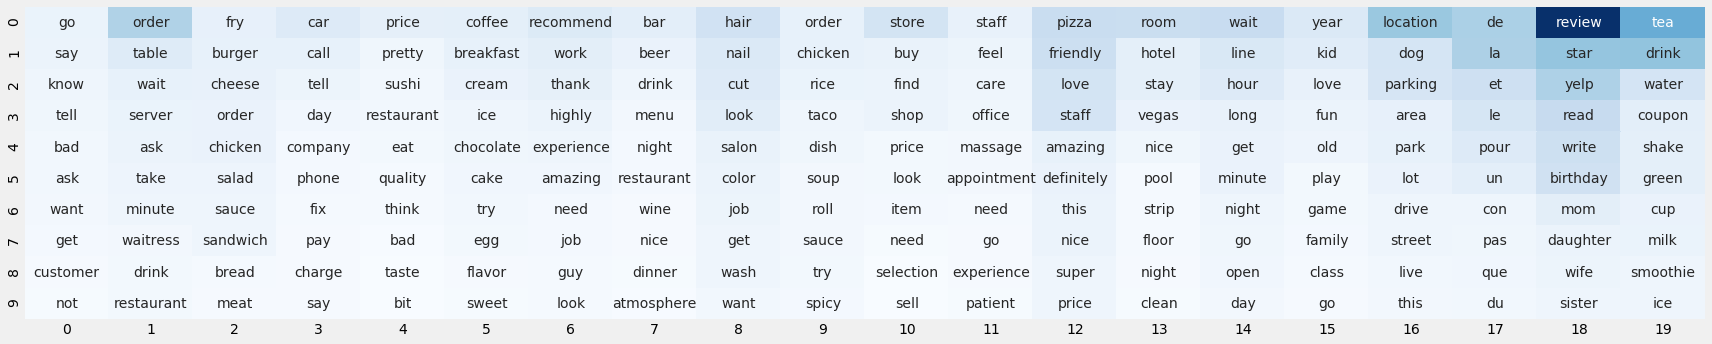

In [54]:
show_word_list(model=exp_lda, corpus=exp_corpus, save=True)

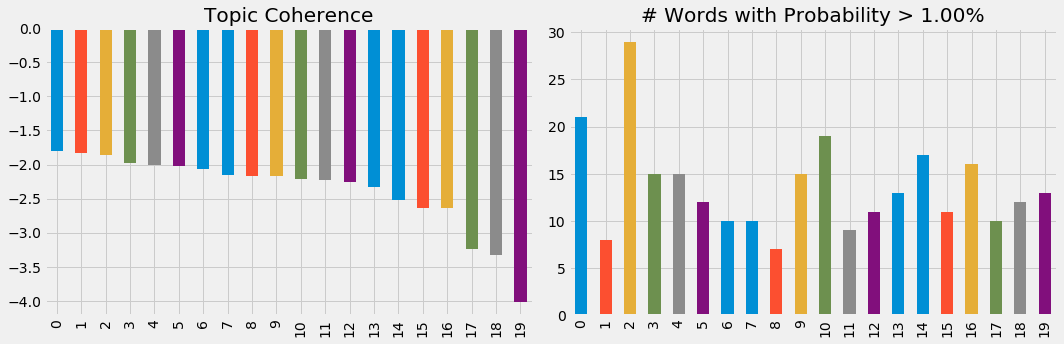

In [55]:
show_coherence(model=exp_lda, corpus=exp_corpus, tokens=exp_tokens)

In [58]:
exp_vis = prepare(exp_lda, exp_corpus, exp_dictionary, mds='tsne')

In [168]:
pyLDAvis.save_html(exp_vis, 'yelp_ldavis.html')

In [71]:
pyLDAvis.display(exp_vis)

In [170]:
terms = exp_vis.topic_info
terms = terms[terms.Category != 'Default']
terms['relevance'] = terms.logprob * .6 + terms.loglift * .4

In [108]:
top_by_relevance = (terms
                    .groupby('Category')
                    .apply(lambda x: x.nlargest(n=10, columns='relevance'))
                    .reset_index('term', drop=True)
                   .loc[:, ['Term', 'relevance']])
top_by_relevance.head()

,Term,relevance
Category,,
Topic1,say,-1.70
Topic1,tell,-1.89
Topic1,know,-1.90
Topic1,bad,-1.91
Topic1,go,-1.98


In [156]:
relevance, terms = pd.DataFrame(), pd.DataFrame()
for topic, data in top_by_relevance.groupby(level='Category'):
    t = topic[:5] + f' {int(topic[5:]):0>2}'
    terms[t] = data.Term.tolist()
    relevance[t] = data.relevance.tolist()

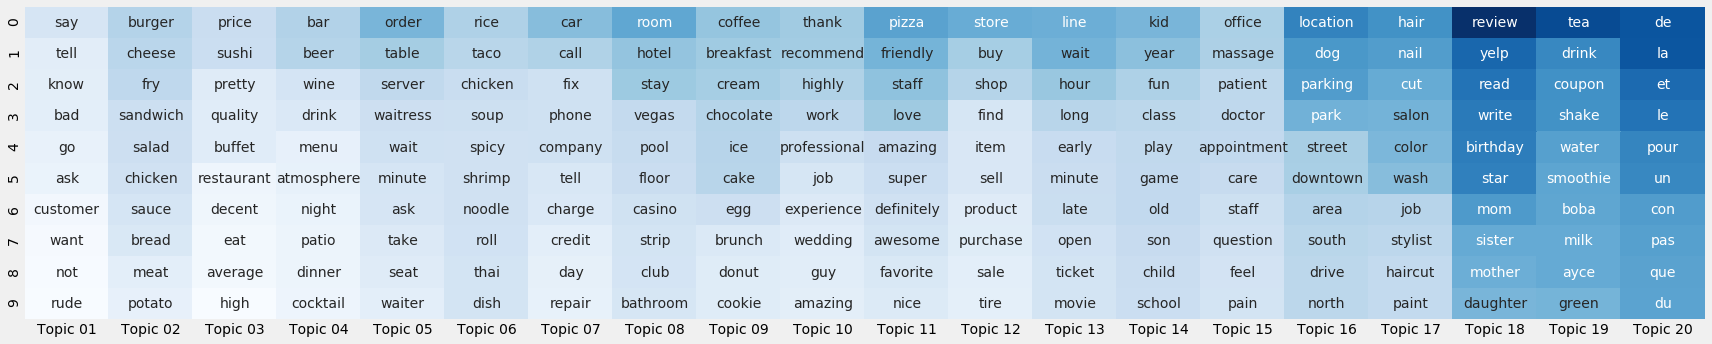

In [159]:
fig, ax = plt.subplots(figsize=(num_topics*1.2, 5))
sns.heatmap(relevance.sort_index(1),
            annot=terms.sort_index(1),
            fmt='',
            ax=ax,
            cmap='Blues',
            cbar=False)
fig.tight_layout()
fig.savefig('yelp_review_wordlist', dpi=300)

## LDAMultiCore Timing

In [160]:
df = pd.read_excel('timings/timings.xlsx')
df.head()

,workers,num_topics,duration,test_perplexity
0,1,10,"2,035.21",72.62
1,1,50,"1,611.58",84.46
2,4,10,"1,093.39",72.74
3,4,50,"1,067.98",82.12
4,8,10,"1,154.87",72.79


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7bf634ae48>,
      dtype=object)

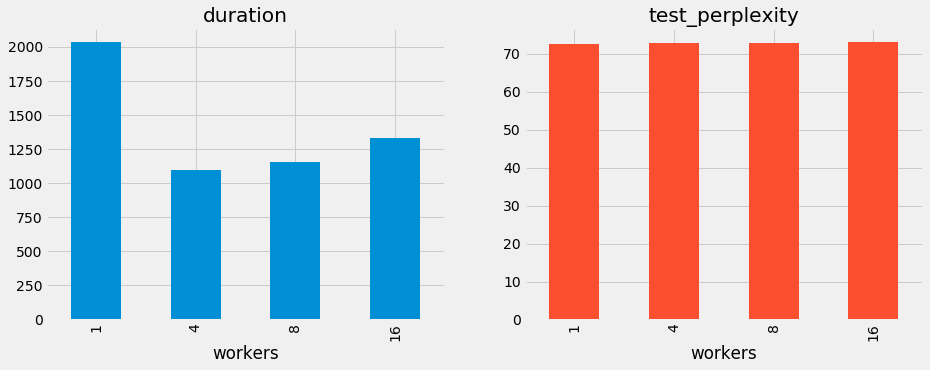

In [167]:
df[df.num_topics==10].set_index('workers')[['duration', 'test_perplexity']].plot.bar(subplots=True, layout=(1,2), figsize=(14,5), legend=False)